# Additive Gaussian Processes

One central limitation of Gaussian Processes (GPs) {cite}`rasmussen2003gaussian` is that they scale poorly with increasing input dimensions. One reason for the poor scaling is that the choice of covariance function has a great impact on the inferred posterior, and naively chosen covariances have an increasingly adverse effect as the number of dimensions is increased. For example, choosing a covariance involving all input variables $x_1, ..., x_D$, such as a member of the RBF family (e.g. EQ or Matern), is equivalent to the prior assumption that the function $f$ being modelled depends jointly on these variables. To model a function $f$ involving interactions between all input variables we need lots of data, since the whole input space must be covered to pin the function sufficiently well throughout the input space. However, in many cases of interest, the data may be explainable via functions with low-order interactions, which can be modelled much more efficiently.

Suppose for example that we wish to predict the CO2 emissions per 100km of a car, $f$, as a function of its horsepower $x_1$ and mass $x_2$. We might choose to model $f$ using a covariance function that is joint in $x_1$ and $x_2$. This prior assumption implies that $f$ itself jointly depends on $x_1$ and $x_2$

$$\begin{align}
k = k(x, x'), x = [x_1, x_2] \implies f = f(x_1, x_2).
\end{align}$$

But we may know for example that the horsepower and weight of the car make independent contributions to the emissions, so that the total CO2 emitted is the sum of two univariate functions $f(x_1, x_2) = f_1(x_1) + f_2(x_2)$, of the horsepower and weight respectively. Such a prior assumption is captured by a sum-separable covariance function of the form

$$\begin{align}
k = k(x_1, x_1') + k(x_2, x_2') \implies f = f_1(x_1) + f_2(x_2).
\end{align}$$

Modelling with this covariance means that much fewer data are required to pin down the function. If the region of interest in our car example is a $W \times H$ rectangle, the first covariance requires $O(WH)$ data to pin down the function since it needs to uniformly cover the input space. On the contrary, the latter requires only $\mathcal{O}(W) + \mathcal{O}(H)$ to achieve the same level of certainty, since it only needs to pin down the univariate functions $f_1$ and $f_2$ to fully determine $f$. In general, we may wish to involve interactions of various degrees in our model. Moreover, we may not know which levels of interactions to include a priori, and may wish to learn these from the data. Additive GPs {cite}`duvenaud2011additive` provide a way for modelling with covariance functions involving the sum of interaction terms of any order, in a computationally efficient way.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import axes3d

from IPython.display import HTML, set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
css_style = open('../../../_static/custom_style.css', 'r').read()
HTML(f'<style>{css_style}</style>')

## Additive covariances

As discussed above, we may not know a priori, what additive structure may be present in our data. Additive GPs directly address this issue by placing a prior which is the sum of all possible kinds of interactions between the input variables. Assuming the inputs lie in $\mathbb{R}^D$ and starting from a collection of univariate _base covariances_ $k_d(x_d, x_d'), d = 1, ..., D$ for each dimension, additive GPs place a covariance of the form

$$\begin{align}
k_{\text{add}}(x, x') = \sum_{d = 1}^D \sigma^2_d k_{\text{add}, d}(x, x')
\end{align}$$

where $k_{\text{add}, d}(x, x')$ itself is of the form

$$\begin{align}
k_{\text{add}, d}(x, x') &= \sum_{1 \leq i_1 < ... < i_d \leq D} \prod_{n = 1}^N k_{i_n}(x_{i_n}, x_{i_n}').
\end{align}$$

For example, in three dimensions the covariance takes the form

$$\begin{align}
k_{\text{add}}(x, x') = &~~\phantom{+} \sigma^2_1 \left(k_1(x_1, x_1') + k_2(x_2, x_2') + k_3(x_3, x_3') \right) \\
                        & + \sigma^2_2 \left(k_1(x_1, x_1')k_2(x_2, x_2') + k_2(x_2, x_2')k_3(x_3, x_3') + k_1(x_1, x_1')k_3(x_3, x_3')\right) \\
                        & + \sigma^2_3 \left(k_1(x_1, x_1')k_2(x_2, x_2')k_3(x_3, x_3') \right).
\end{align}$$

This additive prior allows the GP to model all combinations of interactions of the input variables. The term in the first line models univariate functions, while the terms in the second and third line models functions with all combinations of two and three input variables. The variance coefficients up front allow modulation of each order of interactions, while including private variances within each $k_d$ controls the magnitude of each base covariance in isolation.

However, attempting to naively compute $k_{\text{add}}(x, x')$ is prohibitively expensive, since there are $\mathcal{O}(2^D)$ terms involved in this expression. Fortunately, the Newton-Girard equations provide a much more efficient way to compute the covariance, reducing the cost from $\mathcal{O}(2^D)$ to $\mathcal{O}(D^2)$.

<div class="lemma">
    
**Definition (Newton-Girard formulae)** Let $z_1, ..., z_D \in \mathbb{R}$, $s_k$ be the power sum
    
$$\begin{align}
p_K(z_1, ..., z_D) = P_K = \sum_{d = 1}^D z_d^k.
\end{align}$$
    
and $s_K$ be the symmetric polynomial of order $K < D$, written as

$$\begin{align}
s_K(z_1, ..., z_D) = S_K = \sum_{1 \leq i_1 < ... < i_K \leq K} \prod_{k = 1}^K z_{i_k}.
\end{align}$$
    
The following recursive relation, known as the Newton-Girard formula, holds
    
$$\begin{align}
S_K &= \frac{1}{K} \sum_{k = 1}^{K} (-1)^{k-1} S_{K - k} P_k,
\end{align}$$
 
where we have defined $S_0 = 1$.
    
</div>
<br>

Several proofs of the Newton-Girard formulae are available. Here we present a short one, adapted from [planetmath.org](https://planetmath.org/ProofOfNewtonGirardFormulaForSymmetricPolynomials).

<details class="proof">
<summary>Derivation: Newton-Girard formulae</summary>
    
Starting from the polynomial
    
$$\begin{align}
f(x) &= \prod_{d = 1}^D (1 - z_d x)
\end{align}$$
    
and taking its derivative, we obtain
    
$$\begin{align}
f'(x) &= - f(x)\sum_{d = 1}^D \frac{z_d}{1 - z_d x} \\
      &= \phantom{-} f(x)\sum_{d = 1}^D \sum_{l = 0}^\infty (-1)^{l+1} z_d^{l + 1} x^l \\
      &= \phantom{-} f(x)\sum_{l = 0}^\infty (-1)^{l+1} P_{l + 1} x^l
\end{align}$$
    
Now, noting that the polynomial can also be written as
   
$$\begin{align}
f(x) &=  \sum_{d = 0}^D s_d(z_1, ..., z_D)~x^d \\
     &=  \sum_{d = 0}^D S_d~x^d,
\end{align}$$
    
we take a derivative of this expression to obtain
    
$$\begin{align}
f'(x) &= S_1 + 2S_2 x + ... + D S_D x^{D-1}.
\end{align}$$
    
    
Now equating the two expressions for the derivatives and rearranging to compare coefficients
    
$$\begin{align}
S_1 + 2S_2 x + ... + D S_D x^{D-1} &= \left[\sum_{d = 0}^D S_d~x^d \right] \left[\sum_{l = 0}^\infty (-1)^{l+1} P_{l + 1} x^l\right] \\
                                   &= \left[\sum_{d = 0}^D \sum_{l = 0}^\infty (-1)^{l+1} S_d P_{l + 1} x^{d + l}\right]\\
                                   &= \left[\sum_{n = 0}^\infty (S_n P_1 - ... + (-1)^n S_0 P_{n + 1}) x^n\right]
\end{align}$$
    
we obtain
    
$$\begin{align}
S_K &= \frac{1}{K} \sum_{k = 1}^{K} (-1)^{k-1} S_{K - k} P_k.
\end{align}$$

</details>
<br>

Using the Newton-Girard formula, we can efficiently compute the covariance function up to the desired level of interactions. For a $D$-dimensional problem, we can compute the first $K \leq D$ interactions in $\mathcal{O}(K^2)$ time. Further, we could also use high-order interactions if we so want, by taking differences of a low-order and a high-order interaction covariance.

## Implementation

We can now implement the additive covariance function. Note that the individual covariances $k_i$ can be chosen to have any form we like, and even to have different forms from each other - we could choose for example $k_1$ to be EQ, $k_2$ to be periodic and so on. Here we will take all of $k_i$ to be EQ covariance, implemented below. This `EQKernel` takes `dim` as an argument to specify which entry of the input vector it should use: if `dim = k` is passed, the covariance will act on the $k^{th}$ entry of the input vector.

In [2]:
import tensorflow as tf

class EQKernel(tf.Module):
    
    def __init__(self,
                 lengthscale,
                 variance,
                 dim,
                 dtype,
                 name='eq_kernel',
                 **kwargs):
        
        super().__init__(name=name, **kwargs)
        
        self.dtype = dtype
        self.dim = dim
        
        self.log_lengthscale = np.log(lengthscale)
        self.log_lengthscale = tf.Variable(self.log_lengthscale,
                                           dtype=self.dtype)
        
        self.log_variance = np.log(variance)
        self.log_variance = tf.Variable(self.log_variance,
                                        dtype=self.dtype)
        
        
    def __call__(self, x1, x2):
        
        assert self.dim < x1.shape[-1] == x2.shape[-1]
        
        diff = x1[:, None, self.dim] - x2[None, :, self.dim]
        exp = tf.exp(-0.5 * (diff / tf.exp(self.log_lengthscale)) ** 2)
        exp = tf.exp(self.log_variance) * exp
        
        return exp

We can now implement the additive covariance function. This is a wrapper around a list of first-order covariances, together with a `__call__` function which computes the additive covariance using the Newton-Girard formula presented earlier. The arguments `Kmin` and `Kmax` allow the user to specify the minimum and maximum order of interactions to be included in the covariance.

In [3]:
class AdditiveCovariance(tf.Module):
    
    def __init__(self, covs, variances, noise, dtype, name='addgp', **kwargs):
        
        super().__init__(name=name, **kwargs)
        
        # dtype for the covariance
        self.dtype = dtype
        
        # Set 1st-order covariances and model dimension
        self.covs = covs
        self.dim = len(covs)
        
        # Set log-variances for each order
        self.log_variances = tf.Variable(np.log(variances),
                                         dtype=self.dtype)
        
        # Set log-noise for overall covariance
        self.log_noise = tf.Variable(np.log(noise),
                                     dtype=self.dtype)
        
        
    def P(self, x1, x2):
        
        # Compute 1st-order covariances
        covs = [cov(x1, x2) for cov in self.covs]
        covs = tf.stack(covs, axis=-1)
        
        # Powers in which to raise the covariances
        powers = tf.range(1, self.dim + 1, dtype=self.dtype)
        
        # Raise covariances to powers and sum
        cov_powers = covs[:, :, :, None] ** powers[None, None, None, :]
        cov_powers = tf.reduce_sum(cov_powers, axis=2)
        
        return cov_powers
        
        
    def __call__(self, x1, x2, Kmin=None, Kmax=None, individual_orders=False, add_noise=False):
        
        assert x1.shape[-1] == x2.shape[-1] == self.dim
        
        Kmin = 0 if Kmin is None else Kmin - 1
        Kmax = self.dim if Kmax is None else Kmax
        
        # Compute power sums up-front
        P = self.P(x1, x2)
        
        # List of S matices to use for recursive Newton-Girard
        S = [tf.zeros(shape=(x1.shape[0], x2.shape[0]), dtype=self.dtype) \
             for i in range(self.dim + 1)]
        
        # S0 is 1 by defnition
        S[0] = tf.ones_like(S[0])
        
        # Add kernel contributions by Newton-Girard 
        for i in range(1, min(Kmax, self.dim) + 1):
            for k in range(i):
                
                S[i] = S[i] + (-1) ** k * S[i - k - 1] * P[:, :, k]
                
            S[i] = S[i] / i
            
        # Take out the first S array -- this was used only for the recursion
        S = tf.stack(S[Kmin+1:Kmax+1], axis=-1)
        
        # Multiply by variances for each order
        S = S * tf.exp(self.log_variances)[None, None, Kmin:Kmax]
        
        if individual_orders:
            return S
        
        # Multiply by variances and sum all orders
        cov = tf.reduce_sum(S, axis=2)

        # If required add the diagonal noise term
        if add_noise:
            cov = cov + tf.exp(self.log_noise) * tf.eye(cov.shape[0],
                                                        dtype=dtype)

        return cov

### Sanity checking

To sanity check this implementation, we can compute the covariance using the Newton-Girard method and compare this with the direct (but inefficient) approach. The two methods should give identical answers, which in fact they do.

In [4]:
# Data type to use
dtype = tf.float64

# Number of dimensions to use
num_dim = 2

# Initialise first-order covariances
covs = [EQKernel(lengthscale=1.,
                 variance=1.,
                 dim=i,
                 dtype=tf.float64)
        for i in range(num_dim)]

# Set variance for each order
variances = np.ones(shape=(num_dim,))
noise = 1e-2

# Initialise additive covariance object
add_cov = AdditiveCovariance(covs=covs,
                             variances=variances,
                             noise=noise,
                             dtype=dtype)

# Create random data to pass through covariance
x1 = tf.convert_to_tensor(np.random.randn(5, 2), dtype=dtype)
x2 = tf.convert_to_tensor(np.random.randn(3, 2), dtype=dtype)

# Compute covariance using Newton Girard
newton_girard_cov = add_cov(x1, x2)

print(f'Covariance matrix via Newton-Girard\n{newton_girard_cov}\n')

# Compute covariance directly
direct_cov = covs[0](x1, x2) + covs[1](x1, x2) + \
             covs[0](x1, x2) * covs[1](x1, x2)

print(f'Covariance matrix via direct computation\n{direct_cov}\n')

Covariance matrix via Newton-Girard
[[1.47339647 0.59372449 1.69880744]
 [2.84321461 1.30071419 2.9317356 ]
 [1.68395336 1.25678636 2.50429074]
 [2.46277178 0.98386969 1.63810484]
 [1.25547276 0.83635858 1.74622176]]

Covariance matrix via direct computation
[[1.47339647 0.59372449 1.69880744]
 [2.84321461 1.30071419 2.9317356 ]
 [1.68395336 1.25678636 2.50429074]
 [2.46277178 0.98386969 1.63810484]
 [1.25547276 0.83635858 1.74622176]]



### Sampling the prior

We can now draw samples from the prior and visualise them, to illustrate the difference between the various different orders of interactions.

In [5]:
# Number of dimensions to use
num_dim = 2

# Initialise first-order covariances
covs = [EQKernel(lengthscale=1.,
                 variance=1.,
                 dim=i,
                 dtype=dtype)
        for i in range(num_dim)]

# Set variance for each order. We use a small variance for 2nd order
# interactions in order to better visualise the difference between
# 1st + 2nd order and 2nd order only samples
variances = np.array([1e0, 1e-1])
noise = 1e-2

# Initialise additive covariance object
add_cov = AdditiveCovariance(covs=covs,
                             variances=variances,
                             noise=noise,
                             dtype=dtype)

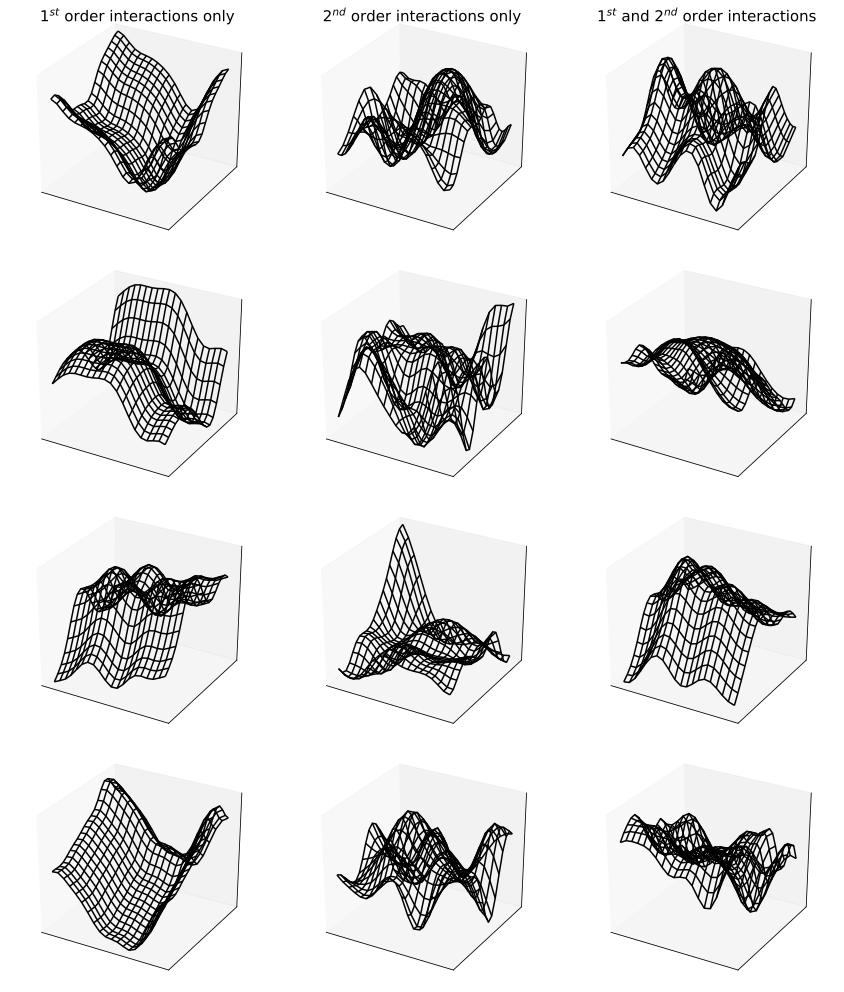

In [6]:
# Set random seed
tf.random.set_seed(0)
    
# Number of points on each grid side, number of samples to draw
num_points = 20
num_samples = 4

# Grid locations to plot
x = np.linspace(-3, 3, num_points)
x = np.stack(np.meshgrid(x, x), axis=2)
x_flat = tf.reshape(x, (num_points ** 2, 2))

x_flat = tf.convert_to_tensor(x_flat, dtype=dtype)

titles = ['$1^{st}$ order interactions only',
          '$2^{nd}$ order interactions only',
          '$1^{st}$ and $2^{nd}$ order interactions']

fig = plt.figure(figsize=(12, 14))

for i in range(num_samples):
    
    for j, title in enumerate(titles):
    
        ax = fig.add_subplot(num_samples, 3, 3*i+j+1, projection='3d')

        if j == 0:
            cov = add_cov(x_flat, x_flat, Kmin=1, Kmax=1)
            
        elif j == 1:
            cov = add_cov(x_flat, x_flat, Kmin=2, Kmax=2)
            
        else:
            cov = add_cov(x_flat, x_flat)
            
        cov = tf.reshape(cov, (num_points ** 2, num_points ** 2))
        cov_chol = tf.linalg.cholesky(cov + 1e-6 * tf.eye(cov.shape[0], dtype=dtype))

        sample = cov_chol @ tf.random.normal(shape=(num_points ** 2, 1), dtype=dtype)
        sample = tf.reshape(sample, (num_points, num_points))

        if i == 0:
            ax.set_title(title, fontsize=15)
            
        ax.plot_wireframe(x[:, :, 0], x[:, :, 1], sample, color='k')
        
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])
        
plt.tight_layout()
plt.show()

We observe that the function draws from the GP with first-order interactions only (left column) look like the sum of two univariate functions, one in $x_1$ and another in $x_2$. Using second-order interactions only produces samples looking like bivariate functions (middle). The additive covariance involving both first and second order interactions produces samples which are the sum of three functions, one in $x_1$ another in $x_2$ and a last one in $x_1, x_2$. Additive covariances could be able to better describe data which exhibit low-order interactions and additive mixtures of interactions of different orders.

### Training and inference

In practice we want to learn the variance parameters $\sigma_1^2, ..., \sigma_D^2$ and the noise level $\sigma^2_n$ from the data. One especially attractive reason to do this, beyond improving our model's fit to the data, is that the inferred variance parameters provide an interpretable metric for the relative magnitude of the contribution of each degree of interaction to the function being modelled. So for example, if we fit the model and discover that one of the variance parameters dominates the others, we know that the data can be well explained by interactions of the corresponding order. This may be a very useful interpretative tool.

The method we use to learn the parameters will be the usual maximum marginal likelihood estimation. The helper `marginal_likelihood` computes this, while the `gp_pred_post` computes the posterior predictive of the distribution.

In [21]:
import tensorflow_probability as tfp
tfd = tfp.distributions

def marginal_likelihood(x, y, covariance):
    
    # Covariance dtype
    dtype = covariance.dtype
    
    # Use a zero mean prior
    mean = tf.zeros_like(y, dtype=dtype)
    
    # Compute the covariance between the datapoints and choleksy-factorise
    cov = covariance(x, x, add_noise=True)
    cov_chol = tf.linalg.cholesky(cov)
    
    # Compute the marginal likelihood
    distribution = tfd.MultivariateNormalTriL(loc=mean, scale_tril=cov_chol)
    marginal_likelihood = distribution.log_prob(y)
    
    return marginal_likelihood


def gp_pred_post(x, y, x_, covariance):
    
    # Compute covariances between training inputs x and prediction inputs x_
    Kxx = covariance(x, x, add_noise=True)
    Kxx_ = covariance(x, x_, add_noise=False)
    Kx_x = covariance(x_, x, add_noise=False)
    Kx_x_ = covariance(x_, x_, add_noise=True)
    
    # Compute predictive mean and covariance
    mean = (Kx_x @ tf.linalg.solve(Kxx, y[:, None]))[:, 0]
    cov = Kx_x_ - Kx_x @ tf.linalg.solve(Kxx, Kxx_)
    
    return mean, cov

## Two-dimensional example

We can now apply additive GPs to some synthetic data. We'll generate data at random from the sum of two sinusoids

$$\begin{align}
f(x_1, x_2) = \text{cos}(2\pi x_1) + \text{cos}(2\pi x_2),
\end{align}$$

then fit an additive GP to this data.

In [13]:
# Set random seed
tf.random.set_seed(0)

# Number of training points
num_data = 15

# Lengthscale and variance of base kernels
num_dim = 2
lengthscale = 1.
cov_variance = 1.
order_variance = 1.

# Generate synthetic data
x_data = 2. * tf.random.uniform((num_data, 2), dtype=dtype) - 1.
y_data = tf.cos(2 * np.pi * x_data[:, 0]) + tf.cos(2 * np.pi * x_data[:, 1])

# Initialise first-order covariances
covs = [EQKernel(lengthscale=lengthscale,
                 variance=cov_variance,
                 dim=i,
                 dtype=dtype)
        for i in range(num_dim)]

# Set variance for each order
variances = order_variance * np.ones(shape=(num_dim,))
noise = 1e-2

# Initialise additive covariance object
add_cov = AdditiveCovariance(covs=covs,
                             variances=variances,
                             noise=noise,
                             dtype=dtype)

# Number of training steps and optimiser
num_steps = 100
optimiser = tf.optimizers.SGD(lr=1e-1)

# Optimiser additive GP hyperparameters
for i in range(num_steps):
    
    with tf.GradientTape() as tape:
        
        tape.watch(add_cov.trainable_variables)
        
        loss = - marginal_likelihood(x_data, y_data, add_cov)
        loss = loss / num_data
        
    gradients = tape.gradient(loss, add_cov.trainable_variables)
    optimiser.apply_gradients(zip(gradients, add_cov.trainable_variables))

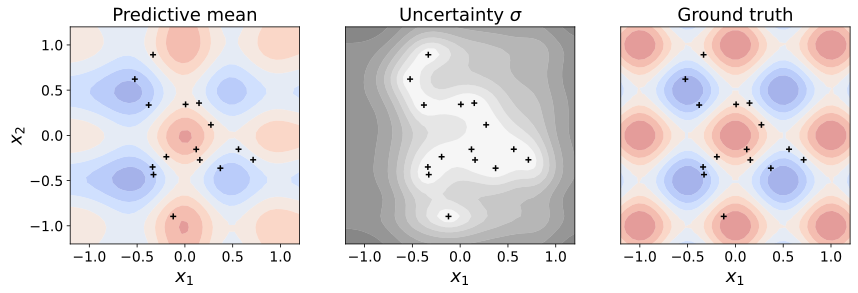

In [14]:
# Number of points on each side of the grid
num_points = 40

# Create grid to predict on
x = np.linspace(-1.2, 1.2, num_points)
x = np.stack(np.meshgrid(x, x), axis=2)
x_flat = tf.reshape(x, (num_points ** 2, 2))

x_flat = tf.convert_to_tensor(x_flat, dtype=dtype)

# True values of the latent function on the grid
y_true = tf.cos(2 * np.pi * x_flat[:, 0]) + tf.cos(2 * np.pi * x_flat[:, 1])
y_true = tf.reshape(y_true, (num_points, num_points))

# Predictive posterior on the grid
pred_mean, pred_cov = gp_pred_post(x_data, y_data, x_flat, add_cov)

# Reshape the predictive mean and marginal variance
pred_mean = tf.reshape(pred_mean, (num_points, num_points))
pred_cov = tf.reshape(tf.linalg.diag_part(pred_cov), (num_points, num_points))

# Figure to plot on
fig = plt.figure(figsize=(14, 4))

# Plot data and predictive mean
plt.subplot(131)
plt.contourf(x[:, :, 0], x[:, :, 1], pred_mean, cmap='coolwarm', alpha=0.5)
plt.scatter(x_data[:, 0], x_data[:, 1], color='k', marker='+')
plt.xticks(np.linspace(-1, 1, 5), fontsize=14)
plt.yticks(np.linspace(-1, 1, 5), fontsize=14)
plt.xlabel('$x_1$', fontsize=18)
plt.ylabel('$x_2$', fontsize=18)
plt.title('Predictive mean', fontsize=18)

# Plot data and predictive variance
plt.subplot(132)
plt.contourf(x[:, :, 0], x[:, :, 1], pred_cov ** 0.5, cmap='binary', alpha=0.5)
plt.scatter(x_data[:, 0], x_data[:, 1], color='k', marker='+')
plt.yticks([])
plt.xticks(np.linspace(-1, 1, 5), fontsize=14)
plt.xlabel('$x_1$', fontsize=18)
plt.title('Uncertainty $\sigma$', fontsize=18)

# Plot ground truth
plt.subplot(133)
plt.contourf(x[:, :, 0], x[:, :, 1], y_true, cmap='coolwarm', alpha=0.5)
plt.scatter(x_data[:, 0], x_data[:, 1], color='k', marker='+')
plt.yticks([])
plt.xticks(np.linspace(-1, 1, 5), fontsize=14)
plt.xlabel('$x_1$', fontsize=18)
plt.title('Ground truth', fontsize=18)

plt.show()

We observe that with rather few datapoints, the model has been able to make sensible and calibrated predictions outside the region of the observed data. For example, the model has made both accurate and precise predictions at the $(1, -1)$ region, even though it has not observed any data there. The model has able to extrapolate outside the training range because it has uncovered the fact that the function is the sum of two univariate functions, which should evident from the variances that it has learnt.

To obtain the variance magnitude of each order, we can compute the covariance function of a zero-input with itself, and return the covariance contributions from each order separately. We observe that the model has discovered that the data is best descibed as the sum of two univariate functions.

In [15]:
zero = tf.zeros(shape=(1, num_dim), dtype=dtype)
sigma1, sigma2 = add_cov(zero, zero, individual_orders=True)[0, 0, :]

print(f'Combined variances: 1st-order {sigma1:.4f} and 2nd-order {sigma2:.4f}.')

Combined variances: 1st-order 1.6385 and 2nd-order 0.1870.


## Example on concrete data

We have tried additive GPs on two-dimensional data, but really the regime of interest is higher-dimensional data. In higher dimensions, we do not have a strong prior for the kinds of interactions between the input variables, nor can we easily visualise it. We'll apply additive GPs to the [UCI concrete compressive strength dataset](http://archive.ics.uci.edu/ml/datasets/concrete+compressive+strength).

In [22]:
@tf.function(jit_compile=True)
def single_step(model, optimiser):
    
    with tf.GradientTape() as tape:
        
        tape.watch(model.trainable_variables)
        
        loss = - marginal_likelihood(x_train, y_train, model)
        loss = loss / num_train
        
    gradients = tape.gradient(loss, model.trainable_variables)
    optimiser.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss

# Load pre-downloaded concrete dataset
x = np.load('data/concrete/x.npy')
y = np.load('data/concrete/y.npy')

# Normalise inputs and outputs
x = (x - x.mean(axis=0)) / x.var(axis=0) ** 0.5
y = (y - y.mean()) / y.var() ** 0.5

# Number of trainint datapoints
num_train = 500

# Training data
x_train = x[:num_train]
y_train = y[:num_train, 0]

# Number of dimensions of the dataset
num_dim = x_train.shape[-1]

# Initialise lengthscale to 1, and set variance so that
# the total variance of the additive GP is 1
lengthcale = 1.
cov_variance = 1.
order_variance = 1.

# Initialise first-order covariances
covs = [EQKernel(lengthscale=lengthscale,
                 variance=cov_variance,
                 dim=i,
                 dtype=tf.float64)
        for i in range(num_dim)]

# Set variance for each order
order_variances = order_variance * np.ones(shape=(num_dim,))

# Initialise additive covariance object
add_cov = AdditiveCovariance(covs=covs,
                             variances=order_variances,
                             noise=noise,
                             dtype=dtype)

# Number of training steps and optimiser
num_steps = 100
optimiser = tf.optimizers.SGD(learning_rate=1e-1)

losses = []

# Optimiser additive GP hyperparameters
for i in range(num_steps):
    
    loss = single_step(add_cov, optimiser)
    losses.append(loss)

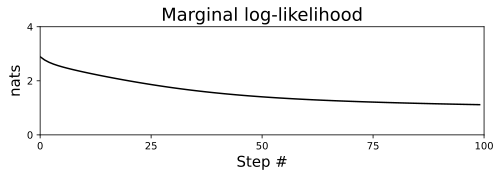

In [23]:
plt.figure(figsize=(8, 2))

plt.plot(np.array(losses), color='k')

plt.title('Marginal log-likelihood', fontsize=18)
plt.xlabel(r'Step #', fontsize=15)
plt.ylabel(r'nats', fontsize=15)

plt.xlim([0, num_steps])
plt.ylim([0, 1])
plt.xticks(np.linspace(0, num_steps, 5))
plt.yticks(np.linspace(0, 4, 3))
plt.show()

We can now have a look at the variances learnt by the model as a means of interpreting it. Remembering that the $d^{th}$ order interaction contains ${D}\choose{d}$ terms and multiplying the variances accordingly, we get an estimate for the relative importance of each order.

In [19]:
zero = tf.zeros(shape=(1, num_dim), dtype=dtype)

combined_variances = add_cov(zero, zero, individual_orders=True)[0, 0, :]
combined_variances = np.round(combined_variances, 2)

print(f'Combined variances: {combined_variances}.')

Combined variances: [3.71 5.35 4.3  2.46 1.05 0.3  0.05 0.  ].


Thus we observe that the data is much better described by low-order interactions between the variables, than high-order interactions.

## Conclusion

Additive GPs provide a way for placing priors over functions involving cross-variable interactions between the input variables. Additive GPs place priors involving any order of interaction that is desirable and automatically learn the importance of each order, directly from the data. Naively computing with the covariance requires exponentially many operations in the number of dimensions, however using the Newton-Girard formulae brings the cost of computing the covariance to $\mathcal{O}(D^2)$. Additive GPs can be effective in practical situations where we have little prior knowledge about the way the input variables interact.

## References

```{bibliography} ./references.bib
```